In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree


sns.set(style="whitegrid", context="notebook")

In [2]:
df = pd.read_csv(
    "amazon_dataset.csv",
    dtype={"order_id": str},
    low_memory=False,
)

columns_to_remove = [
    # "bi_st",
    "cust_id",
    "ref_num",
    "First Name",
    "Middle Initial",
    "Last Name",
    "full_name",
    "E Mail",
    "Phone No. ",
    "User Name",
]

df = df.drop(columns=columns_to_remove, errors="ignore")

df.head()

,order_id,order_date,status,item_id,sku,qty_ordered,price,value,discount_amount,total,...,Gender,age,Sign in date,Place Name,County,City,State,Zip,Region,Discount_Percent
0,100354678,01/10/2020,received,574772,oasis_Oasis-064-36,21,89.9,1798.0,0.0,1798.0,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0
1,100354678,01/10/2020,received,574774,Fantastic_FT-48,11,19.0,190.0,0.0,190.0,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0
2,100354680,01/10/2020,complete,574777,mdeal_DMC-610-8,9,149.9,1199.2,0.0,1199.2,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0
3,100354680,01/10/2020,complete,574779,oasis_Oasis-061-36,9,79.9,639.2,0.0,639.2,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0
4,100367357,13/11/2020,received,595185,MEFNAR59C38B6CA08CD,2,99.9,99.9,0.0,99.9,...,F,43,8/22/2006,Vinson,Harmon,Vinson,OK,73571,South,0.0


In [3]:
status_complete = {"complete", "received"}
status_incomplete = {"canceled", "order_refunded", "refund"}
eligible_statuses = status_complete | status_incomplete

filtered = df[df["status"].isin(eligible_statuses)].copy()
filtered["order_complete"] = filtered["status"].isin(status_complete).astype(int)

status_summary = filtered["status"].value_counts().rename_axis("status").reset_index(name="count")
status_summary

,status,count
0,canceled,112166
1,complete,88968
2,received,51775
3,order_refunded,25713
4,refund,3820


In [4]:
model_df = filtered.copy()

model_df["order_date"] = pd.to_datetime(model_df["order_date"], dayfirst=True, errors="coerce")
model_df["signin_date"] = pd.to_datetime(model_df["Sign in date"], errors="coerce")
model_df["order_month"] = model_df["order_date"].dt.month
model_df["order_day"] = model_df["order_date"].dt.day
model_df["order_dayofweek"] = model_df["order_date"].dt.dayofweek
model_df["signup_years_active"] = (
    (model_df["order_date"] - model_df["signin_date"]).dt.days / 365.25
)

numeric_features = [
    "qty_ordered",
    "price",
    "value",
    "discount_amount",
    "total",
    "age",
    "year",
    "Discount_Percent",
    "order_month",
    "order_day",
    "order_dayofweek",
    "signup_years_active",
]

for col in numeric_features:
    model_df[col] = pd.to_numeric(model_df[col], errors="coerce")

categorical_features = [
    "category",
    "payment_method",
    # "bi_st",
    "Gender",
    "Region",
    "State",
]

feature_cols = numeric_features + categorical_features

data = model_df[feature_cols + ["order_complete"]].dropna(subset=["order_complete"])
data.head()

,qty_ordered,price,value,discount_amount,total,age,year,Discount_Percent,order_month,order_day,order_dayofweek,signup_years_active,category,payment_method,Gender,Region,State,order_complete
0,21,89.9,1798.0,0.0,1798.0,43,2020,0.0,10,1,3,14.110883,Men's Fashion,cod,F,South,OK,1
1,11,19.0,190.0,0.0,190.0,43,2020,0.0,10,1,3,14.110883,Men's Fashion,cod,F,South,OK,1
2,9,149.9,1199.2,0.0,1199.2,43,2020,0.0,10,1,3,14.110883,Men's Fashion,cod,F,South,OK,1
3,9,79.9,639.2,0.0,639.2,43,2020,0.0,10,1,3,14.110883,Men's Fashion,cod,F,South,OK,1
4,2,99.9,99.9,0.0,99.9,43,2020,0.0,11,13,4,14.228611,Men's Fashion,cod,F,South,OK,1


In [5]:
X = data[feature_cols]
y = data["order_complete"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01),
        ),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

tree_clf = DecisionTreeClassifier(random_state=42, class_weight=None)
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", tree_clf),
    ]
)

param_grid = {
    # "classifier__max_depth": [4, 6, 8, 10, 12],
    # "classifier__min_samples_split": [2, 10, 25, 50],
    # "classifier__min_samples_leaf": [1, 5, 10, 25],
    "classifier__max_depth": [12],
    "classifier__min_samples_split": [2],
    "classifier__min_samples_leaf": [1],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.3f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier__max_depth': 12, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best CV accuracy: 0.716


Test accuracy: 0.719
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.71     28340
           1       0.70      0.75      0.73     28149

    accuracy                           0.72     56489
   macro avg       0.72      0.72      0.72     56489
weighted avg       0.72      0.72      0.72     56489



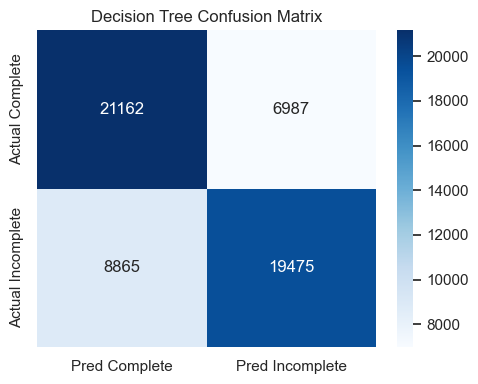

In [6]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.3f}")
print("Classification report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
cm_df = pd.DataFrame(cm, index=["Actual Complete", "Actual Incomplete"], columns=["Pred Complete", "Pred Incomplete"])

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.tight_layout()
plt.show()


C:\Users\karen\AppData\Local\Temp\ipykernel_35632\964385117.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


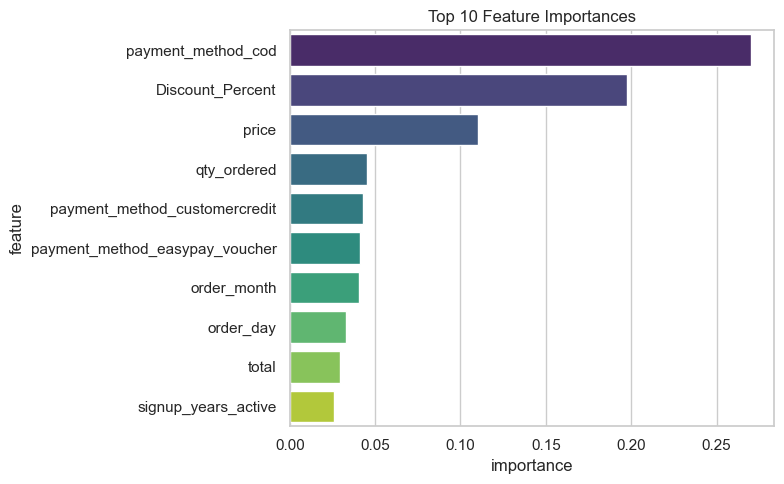

In [7]:
best_tree = best_model.named_steps["classifier"]
preprocess = best_model.named_steps["preprocessor"]

num_feature_names = numeric_features
cat_encoder = preprocess.named_transformers_["cat"].named_steps["encoder"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

importance_df = (
    pd.DataFrame({"feature": all_feature_names, "importance": best_tree.feature_importances_})
    .sort_values(by="importance", ascending=False)
)

importance_df.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=importance_df.head(10),
    x="importance",
    y="feature",
    palette="viridis",
)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


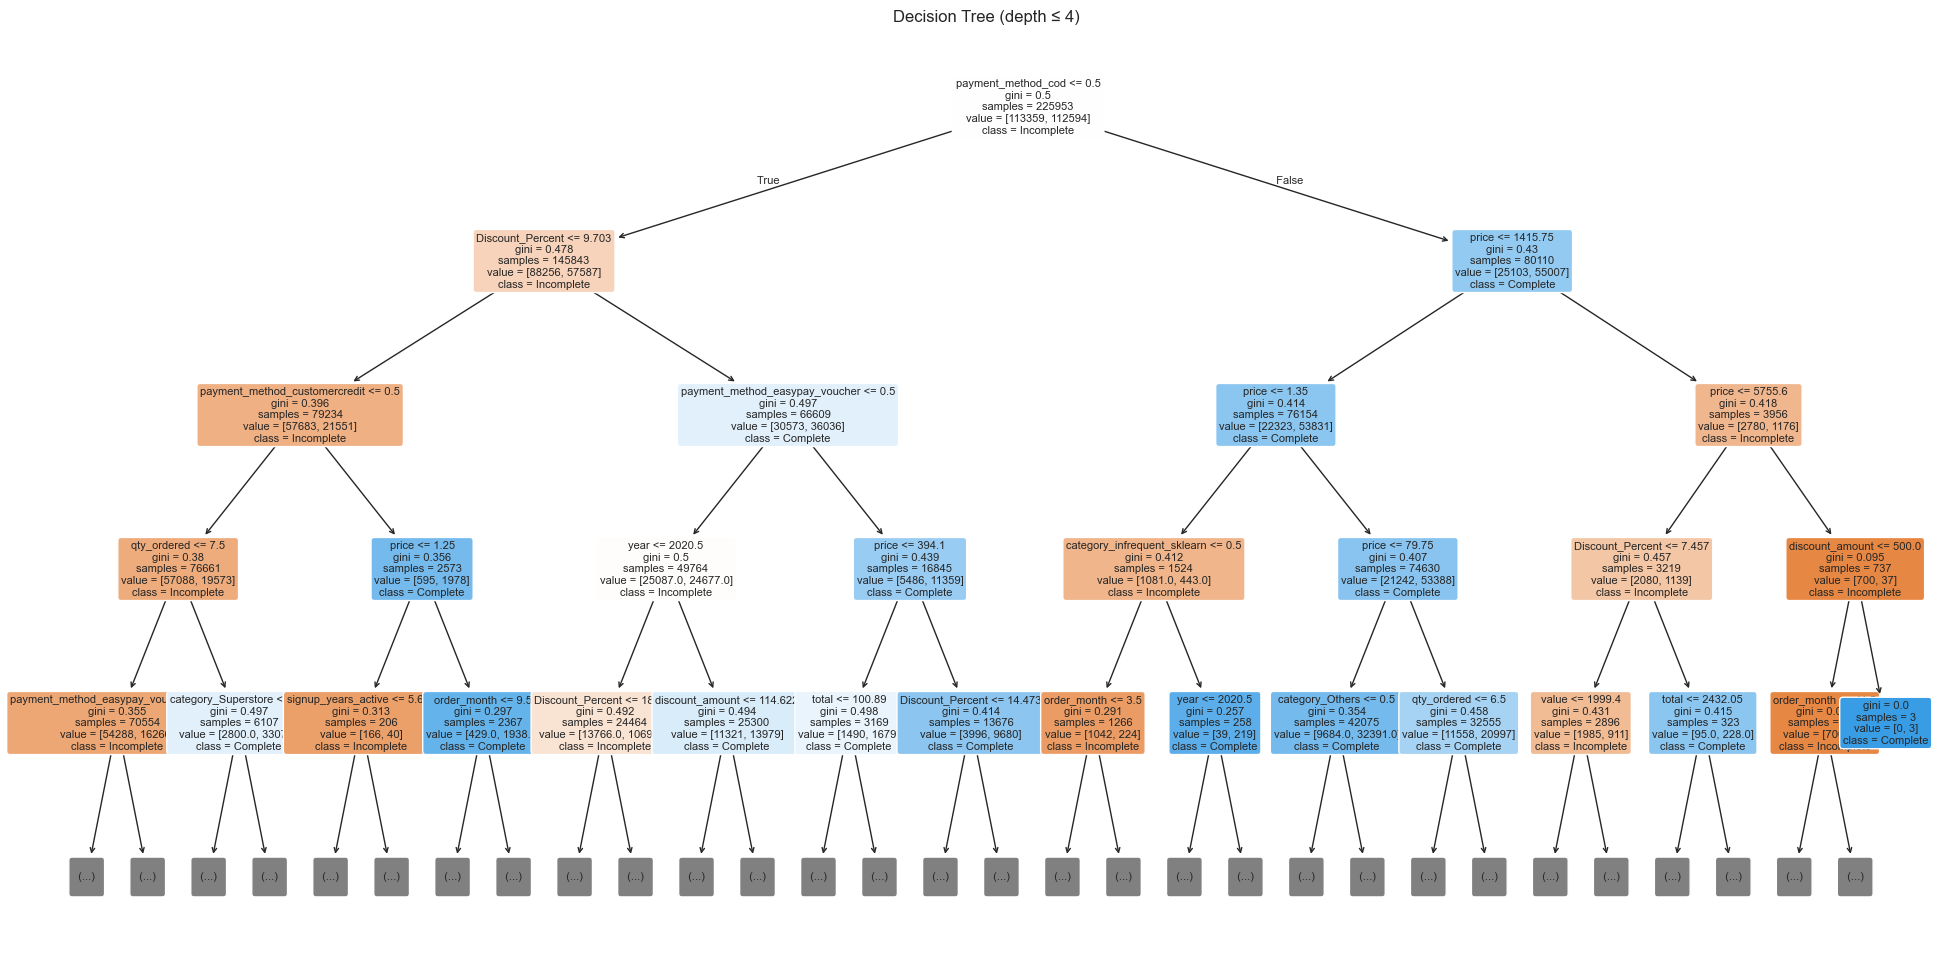

In [8]:
plt.figure(figsize=(24, 12))
plot_tree(
    best_tree,
    feature_names=all_feature_names,
    class_names=["Incomplete", "Complete"],
    filled=True,
    rounded=True,
    max_depth=4,
    fontsize=8,
)
plt.title("Decision Tree (depth ≤ 4)")
plt.show()


In [ ]:
def get_feature_usage(tree, feature_names):
    tree_ = tree.tree_
    feature_usage = {}
    
    def recurse(node, depth):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature_idx = tree_.feature[node]
            feature_name = feature_names[feature_idx]
            feature_usage[feature_name] = feature_usage.get(feature_name, 0) + 1
            recurse(tree_.children_left[node], depth + 1)
            recurse(tree_.children_right[node], depth + 1)
    
    recurse(0, 1)
    return feature_usage

usage = get_feature_usage(best_tree, all_feature_names)
usage_df = pd.DataFrame(list(usage.items()), columns=['feature', 'usage_count']).sort_values('usage_count', ascending=False)
print("Features by number of times used in tree:")
print(usage_df.head(10))

Features by number of times used in tree:
                feature  usage_count
8   signup_years_active          181
10            order_day          149
9                   age          124
15                price          119
5                 total           81
12      order_dayofweek           77
20                value           71
6           order_month           69
1      Discount_Percent           68
75      discount_amount           40


In [10]:
def get_tree_paths(tree, feature_names, class_names, max_paths=10):
    tree_ = tree.tree_
    paths = []
    
    def recurse(node, depth, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature_idx = tree_.feature[node]
            threshold = tree_.threshold[node]
            feature_name = feature_names[feature_idx]
            
            left_path = path + [f"  {'  ' * depth}IF {feature_name} <= {threshold:.2f}"]
            recurse(tree_.children_left[node], depth + 1, left_path)
            
            right_path = path + [f"  {'  ' * depth}IF {feature_name} > {threshold:.2f}"]
            recurse(tree_.children_right[node], depth + 1, right_path)
        else:
            samples = tree_.n_node_samples[node]
            value = tree_.value[node][0]
            predicted_class = class_names[np.argmax(value)]
            class_probs = value / value.sum()
            
            path_str = "\n".join(path)
            leaf_info = f"  {'  ' * depth}→ LEAF: Predict '{predicted_class}'"
            leaf_info += f" (samples: {samples}, prob: {class_probs[1]:.3f})"
            
            paths.append({
                'path': path_str + "\n" + leaf_info,
                'depth': depth,
                'samples': samples,
                'prediction': predicted_class,
                'probability': class_probs[1] if predicted_class == 'Complete' else class_probs[0]
            })
    
    recurse(0, 0, [])
    
    paths.sort(key=lambda x: x['samples'], reverse=True)
    
    return paths[:max_paths]

paths = get_tree_paths(best_tree, all_feature_names, ["Incomplete", "Complete"], max_paths=10)

print("COMPLETE DECISION TREE PATHS (Top 10 by sample count)\n")
print()

for i, path_info in enumerate(paths, 1):
    print(f"PATH {i}: {path_info['prediction']} (Probability: {path_info['probability']:.3f}, Samples: {path_info['samples']})\n")
    print(path_info['path'])
    print()


COMPLETE DECISION TREE PATHS (Top 10 by sample count)


PATH 1: Complete (Probability: 0.745, Samples: 10706)

  IF payment_method_cod > 0.50
    IF price <= 1415.75
      IF price > 1.35
        IF price <= 79.75
          IF category_Others <= 0.50
            IF price > 37.90
              IF order_month <= 11.50
                IF order_month <= 10.50
                  IF qty_ordered <= 4.50
                    IF category_Mobiles & Tablets <= 0.50
                      IF order_day <= 28.50
                        IF category_Soghaat <= 0.50
                          → LEAF: Predict 'Complete' (samples: 10706, prob: 0.745)

PATH 2: Complete (Probability: 0.787, Samples: 8652)

  IF payment_method_cod > 0.50
    IF price <= 1415.75
      IF price > 1.35
        IF price <= 79.75
          IF category_Others <= 0.50
            IF price <= 37.90
              IF order_month <= 11.50
                IF category_Mobiles & Tablets <= 0.50
                  IF category_Men's Fashion <= 